# VGG-19 CNN Model testing

On va se baser sur un modèle de type VGG19 auquel nous rajouterons un CNN, comme fait dans l'article  : "Deep-chest: Multi-classification deep learning model for diagnosing COVID-19, pneumonia, and lung cancer chest diseases" de Ibrahim M. D. et al.

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from PIL import Image
import shutil

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch, HyperParameters
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data import Dataset, random_split, Subset

In [2]:
# # Run this cell once if you want to delete your tuner

# # Define the path to the tuner directory
# tuner_directory = '/kaggle/working/COVID-EX-Qu-dataset/hparam_tuning_lr_vgg19CNN'

# # Check if the directory exists
# if os.path.exists(tuner_directory):
#     # Delete the directory
#     shutil.rmtree(tuner_directory)
#     print(f"Tuner directory {tuner_directory} deleted successfully!")
# else:
#     print("Directory does not exist.")

Tuner directory /kaggle/working/COVID-EX-Qu-dataset/hparam_tuning_lr_vgg19CNN deleted successfully!


# **1. Settings and data readings**

In [3]:
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

## 1.1 Image Normalization

In [4]:
def preprocess_image(img):
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image, 
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [ ]:
# Run this cell only once to save images data in working directory (+ select persitance of files in Session options)
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in os.listdir(ima_dir):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [5]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="categorical",
                                                           target_size=(224, 224),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="categorical",
                                                         target_size=(224, 224),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="categorical",
                                                          target_size=(224, 224),
                                                          batch_size=batch_size, shuffle=False)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


## 1.2 Checking Data Integrity

In [7]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found in the Drive, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found in the Drive, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


# **2. Tuning et entraînement du meilleur modèle**

On récupère l'ossature du modèle utilisé dans l'article et on le tune sur nos données.

## 3.1 Définition du modèle



In [8]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [9]:
def build_model(hp):
    base_vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_vgg19.trainable = False  # Freeze the VGG19 layers

    model = models.Sequential([
        base_vgg19,
        layers.Reshape((7, 7, 512)),
        layers.Conv2D(128, (3, 3), name='conv2d_1'),
        layers.Activation('relu', name='activation_1'),
        layers.BatchNormalization(name='batch_normalization'),
        layers.MaxPooling2D((2, 2), name='max_pooling2d'),
        layers.Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.8, step=0.1)),
        layers.Flatten(name='flatten'),
        layers.Dense(hp.Int('units', min_value=128, max_value=512, step=128), name='dense'),
        layers.Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.8, step=0.1)),
        layers.Dense(3, activation='softmax', name='dense_1') 
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.00001, 0.00006, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
# Create a tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of variations on model
    executions_per_trial=1,  # Number of models to train per trial
    directory='/kaggle/working/COVID-EX-Qu-dataset',  # Directory to save logs
    project_name='hparam_tuning_lr_vgg19CNN'
)

# Display search space summary
tuner.search_space_summary()

Reloading Tuner from /kaggle/working/COVID-EX-Qu-dataset/hparam_tuning_lr_vgg19CNN/tuner0.json
Search space summary
Default search space size: 4
dropout_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 1e-05, 'conditions': [], 'values': [1e-05, 6e-05, 0.0001], 'ordered': True}


In [40]:
# # Perform the hyperparameter search
# tuner.search(train_generator, 
#              epochs=10, 
#              validation_data=val_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Retrieve and read tuned parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal dropout rate 1 is {best_hps.get('dropout_1')}.
The optimal dropout rate 2 is {best_hps.get('dropout_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal number of neurons in dense layer is {best_hps.get('units')}.
""")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,879,043 (79.65 MB)

 Trainable params: 854,403 (3.26 MB)

 Non-trainable params: 20,024,640 (76.39 MB)


The optimal dropout rate 1 is 0.3.
The optimal dropout rate 2 is 0.6000000000000001.
The optimal learning rate is 6e-05.
The optimal number of neurons in dense layer is 512.



## 3.2 Training

In [13]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001)

# Training
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,  # Adjust epochs according to your needs
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/678 ━━━━━━━━━━━━━━━━━━━━ 7:51:47 42s/step - accuracy: 0.9375 - loss: 0.2844

I0000 00:00:1714638036.692153     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714638036.715611     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7702 - loss: 0.5939

W0000 00:00:1714638332.117803     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 364s 476ms/step - accuracy: 0.7702 - loss: 0.5939 - val_accuracy: 0.8356 - val_loss: 0.4068
Epoch 2/40
  1/678 ━━━━━━━━━━━━━━━━━━━━ 1:48 161ms/step - accuracy: 0.6875 - loss: 0.6435

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6875 - loss: 0.6435 - val_accuracy: 0.8889 - val_loss: 0.6164
Epoch 3/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 297s 434ms/step - accuracy: 0.7688 - loss: 0.5761 - val_accuracy: 0.8212 - val_loss: 0.4529
Epoch 4/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.8438 - loss: 0.4015 - val_accuracy: 1.0000 - val_loss: 0.1003
Epoch 5/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 296s 432ms/step - accuracy: 0.7837 - loss: 0.5548 - val_accuracy: 0.8262 - val_loss: 0.4345
Epoch 6/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.8750 - loss: 0.4580 - val_accuracy: 1.0000 - val_loss: 0.2274
Epoch 7/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 297s 434ms/step - accuracy: 0.7869 - loss: 0.5412 - val_accuracy: 0.8419 - val_loss: 0.4033
Epoch 8/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 119us/step - accuracy: 0.8125 - loss: 0.5684 - val_accuracy: 0.8889 - val_loss: 0.3288
Epoch 9/40
678/678 ━━━━━━━━━━━━━━━━━━━━ 297s 433ms/step - accuracy: 0.7936 - loss: 0.5206 - val

# **4. Evaluation du modèle**

## 4.1 Métriques

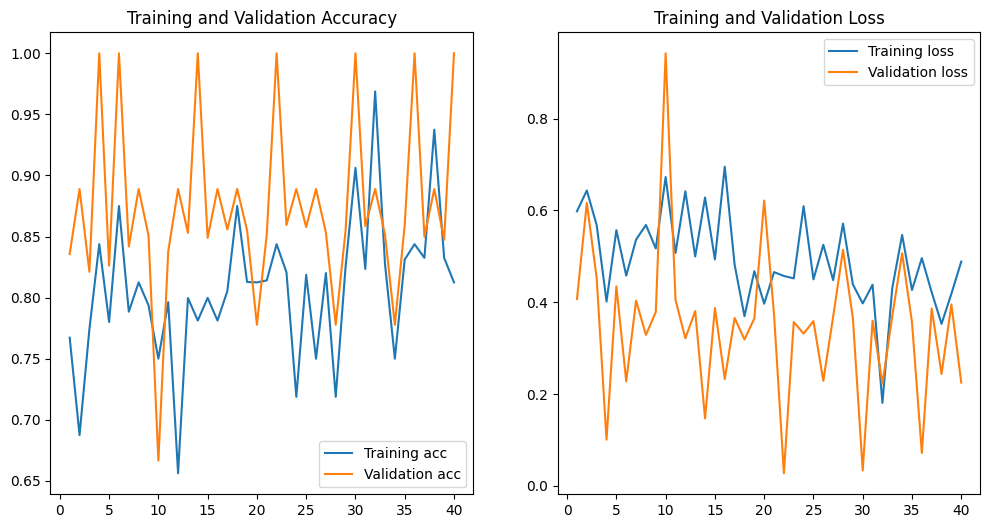

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show();

## 4.2 Evaluation du modèle

In [15]:
test_loss, test_acc = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test accuracy:', test_acc)



212/212 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.7965 - loss: 0.5062
Test accuracy: 0.8528891801834106


In [16]:
# Predict the output (the predict method returns the probabilities per class for each sample)
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
test_generator.reset()
predictions = best_model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the list of class labels

  2/213 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step 

W0000 00:00:1714644093.795812     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step


In [17]:
# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    COVID-19       0.97      0.75      0.85      2395
   Non-COVID       0.85      0.89      0.87      2253
      Normal       0.77      0.93      0.84      2140

    accuracy                           0.85      6788
   macro avg       0.86      0.86      0.85      6788
weighted avg       0.87      0.85      0.85      6788



/tmp/ipykernel_34/1875443584.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_labels, rotation=90)
/tmp/ipykernel_34/1875443584.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_labels)


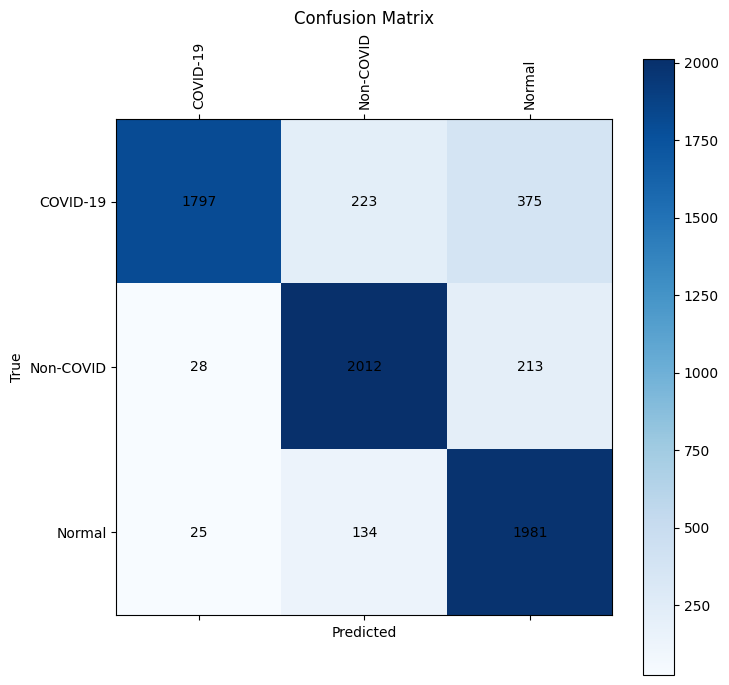

In [18]:
# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels, rotation=90)
ax.set_yticklabels([''] + class_labels)

# Annotate the matrix with text
for i in range(len(cm)):
    for j in range(len(cm[i])):
        ax.text(j, i, str(cm[i, j]), va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show();

# 5. More fine tuning

In [31]:
# Rebuild the model using the best hyperparameters found
best_hp = tuner.get_best_hyperparameters()[0]
best_model = build_model(best_hp)

Unfreeze les dernières couches du modèle, surtout dans le cas d'un modèle pré entraîné comme VGG sur d'autres images, peut permettre d'améliorer
la performance de celui-ci sur des images différentes de celles de son pré-entraînement.

In [32]:
# Assume base_vgg19 is part of best_model and is the first layer in the Sequential model
base_vgg19 = best_model.layers[0]  # This accesses the VGG19 model, assuming it is wrapped by `Sequential`

# Unfreeze the last 4 layers of the base VGG19 model
for layer in base_vgg19.layers[-5:]:
    layer.trainable = True

# It's a good practice to check which layers are trainable
for layer in base_vgg19.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [33]:
# Recompile the model to apply the changes with a lower learning rate
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00006),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [34]:
# Continue training the model
history = best_model.fit(
    train_generator,
    epochs=30,  # Number of additional epochs to train
    validation_data=val_generator,
    verbose=1  # Show training progress
)

Epoch 1/30
  1/679 ━━━━━━━━━━━━━━━━━━━━ 2:17:17 12s/step - accuracy: 0.4062 - loss: 3.2995

W0000 00:00:1714647922.537113     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6178 - loss: 1.3504

W0000 00:00:1714648185.334197     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


679/679 ━━━━━━━━━━━━━━━━━━━━ 302s 428ms/step - accuracy: 0.6179 - loss: 1.3497 - val_accuracy: 0.7975 - val_loss: 0.5294
Epoch 2/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 286s 417ms/step - accuracy: 0.7947 - loss: 0.5208 - val_accuracy: 0.8955 - val_loss: 0.2744
Epoch 3/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 285s 416ms/step - accuracy: 0.8364 - loss: 0.4244 - val_accuracy: 0.8837 - val_loss: 0.3046
Epoch 4/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 285s 416ms/step - accuracy: 0.8569 - loss: 0.3787 - val_accuracy: 0.8791 - val_loss: 0.3041
Epoch 5/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 290s 423ms/step - accuracy: 0.8672 - loss: 0.3478 - val_accuracy: 0.8684 - val_loss: 0.3365
Epoch 6/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 285s 416ms/step - accuracy: 0.8715 - loss: 0.3312 - val_accuracy: 0.8652 - val_loss: 0.3448
Epoch 7/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 286s 416ms/step - accuracy: 0.8772 - loss: 0.3195 - val_accuracy: 0.8555 - val_loss: 0.3810
Epoch 8/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 285s 415ms/step - accuracy: 0.8872 - loss: 0.29

In [35]:
test_loss, test_acc = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

212/212 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.9080 - loss: 0.2915
Test accuracy: 0.9189268946647644
Test loss: 0.24911920726299286


In [36]:
# Predict the output (the predict method returns the probabilities per class for each sample)
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
test_generator.reset()
predictions = best_model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get the list of class labels

  2/213 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step 

W0000 00:00:1714656747.828244     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step


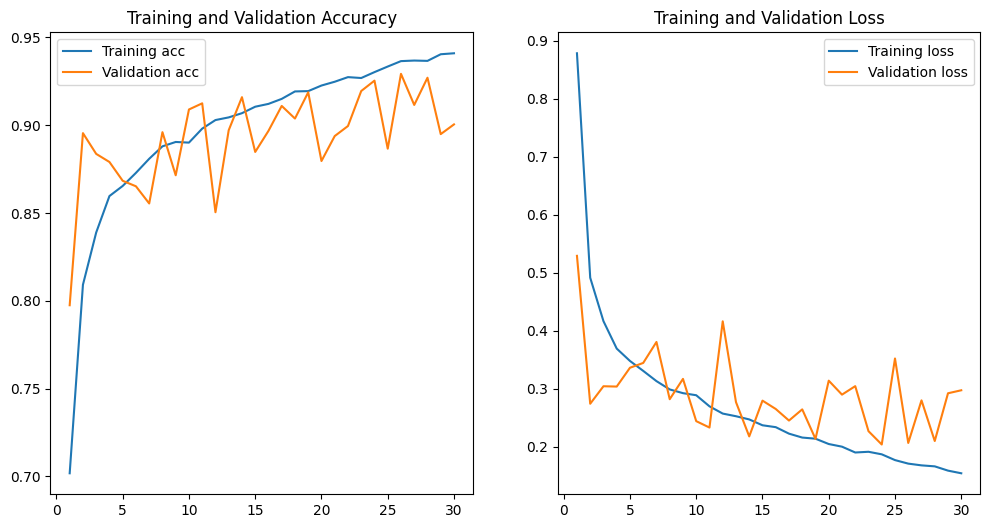

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show();

In [38]:
# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    COVID-19       0.99      0.91      0.95      2395
   Non-COVID       0.94      0.88      0.91      2253
      Normal       0.84      0.97      0.90      2140

    accuracy                           0.92      6788
   macro avg       0.92      0.92      0.92      6788
weighted avg       0.93      0.92      0.92      6788



/tmp/ipykernel_34/1875443584.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_labels, rotation=90)
/tmp/ipykernel_34/1875443584.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_labels)


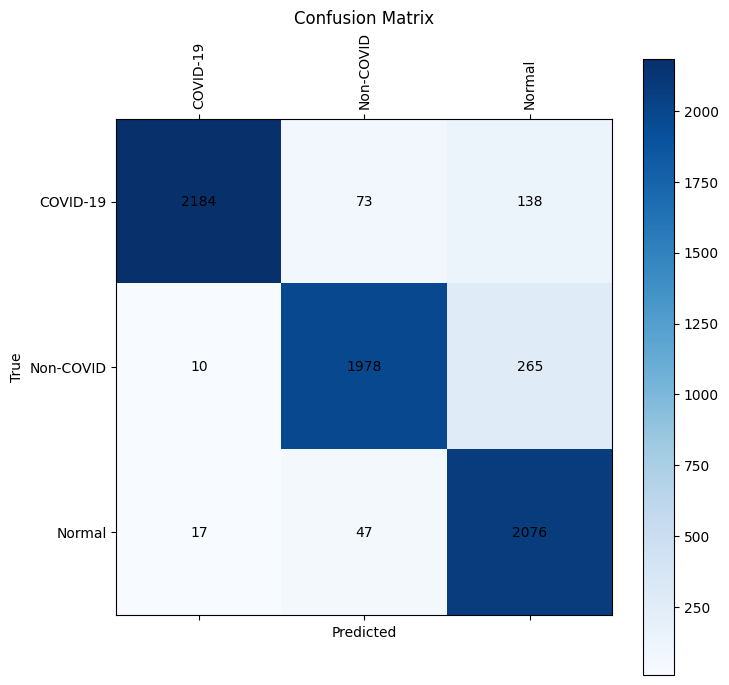

In [39]:
# Generate a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels, rotation=90)
ax.set_yticklabels([''] + class_labels)

# Annotate the matrix with text
for i in range(len(cm)):
    for j in range(len(cm[i])):
        ax.text(j, i, str(cm[i, j]), va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show();